Given
$ \displaystyle
    \frac{d^2 y}{d x^2} - k \frac{y}{1 + y} = 0
$
find $y$

# DARTS

$ \displaystyle
\overline{o}^{(i, j)}(x) = \sum_{o \in \mathcal{O}} \left( \alpha_o^{(i,j)} o(x) \right)
\\ \displaystyle
\forall (i, j) \; R = (\sum_{o \in \mathcal{O}} \alpha_o^{(i, j)} - 1)^2
$

# Code

In [32]:
import sympy as sp
from jax import random
from jax import config as jax_config
import jax.numpy as np

jax_config.update('jax_platform_name', 'cpu')

# !rm /etc/localtime
# !ln -s /usr/share/zoneinfo/Europe/Vilnius /etc/localtime

from util.plot import Plotting
from util.print import a, d, pad, info
from util.dotdict import DotDict
from network import Network
from train import train

In [33]:
c1 = sp.symbols('c_1')
x_bounds = (0, 1)
c1_bounds = (0.01, 0.1)

In [34]:
loss_model_func = lambda model_y, x, model_d2y: sp.Pow(model_d2y - c1 * (model_y) / (1 + model_y), 2, evaluate=False)
loss_integration_func = lambda loss_model: (loss_model, (c1, *c1_bounds))

In [35]:
cell_count = 4
network = Network(
  loss_model_func,
  loss_integration_func,
  [
    lambda z: 0,
    lambda z: 1,
    lambda z: z,
    lambda z: 1 + z,
    lambda z: -z,
    lambda z: z*z,
    lambda z: z*z*z*z,
    lambda z: sp.exp(z),
    # lambda z: (sp.exp(z) + sp.exp(-z)) / 2,
    # lambda z: sp.sin(z),
    # lambda z: 1 / (1 + sp.exp(-z))
  ],
  cell_count,
  x_bounds,
  verbose=1
)

_, model_y, loss_and_grad, _ = network.get_model()

13:47:08.407 [INFO] Constructed symbolic model
13:47:08.435 [INFO] Integrated
13:47:08.967 [INFO] Added boundary condition
13:47:09.724 [INFO] Lambdified
13:47:09.724 [INFO] Constructed JAXified model


In [36]:
def orig_func_klow(x, sigma_sq):
  S_0 = 1
  d = 1
  alpha = np.sqrt(sigma_sq) / d
  return S_0 * np.cosh(alpha * x) / np.cosh(alpha * d)

def orig_func_khi(x, sigma_sq):
  S_0 = 1
  d = 1

  # typical ks
  k1 = 10 ** 7
  kneg1 = 500
  k2 = 500

  K_M = (kneg1 + k2)/k1

  V_max_over_2_D_S = sigma_sq * K_M / (2*d*d)
  return S_0 + V_max_over_2_D_S * (x * x - d * d)

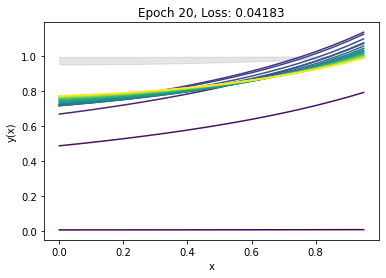

13:47:13.875 [INFO] W = [ 0.1677,  0.1291,  0.1180,  0.0788,  0.2172,  0.0999,  0.0579,  0.0243,  0.1680,  0.1292,  0.1188,  0.0803,  0.2174,  0.0993,  0.0573,  0.0245,  0.1736,  0.1433,  0.1363,  0.1060,  0.2133,  0.0880,  0.0001,  0.0272,  0.1431,  0.1045,  0.1171,  0.0787,  0.1699,  0.1268,  0.1375,  0.0680,  0.1463,  0.1150,  0.1070,  0.0767,  0.1850,  0.1173,  0.1350,  0.0582,  0.1640,  0.1323,  0.1048,  0.0734,  0.2225,  0.0956,  0.0918,  0.0241, -0.0301]
13:47:13.877 [INFO] Pruning weights...
13:47:13.884 [INFO] Shed 0.024276049807667732 weight
13:47:14.450 [INFO] Constructed symbolic model
13:47:14.780 [INFO] Integrated
13:47:14.539 [INFO] Added boundary condition
13:47:15.135 [INFO] Lambdified
13:47:15.136 [INFO] Constructed JAXified model


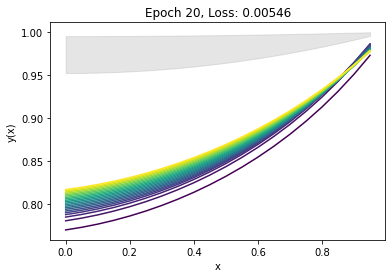

13:47:19.240 [INFO] W = [ 0.1757,  0.1301,  0.1164,  0.0702,  0.2347,  0.0915,  0.0360,  0.1943,  0.1462,  0.1320,  0.0842,  0.2567,  0.1045,  0.0464,  0.0111,  0.1981,  0.1671,  0.1575,  0.1264,  0.2412,  0.0781,  0.0001,  0.0147,  0.1541,  0.1063,  0.1231,  0.0755,  0.1861,  0.1356,  0.1482,  0.0634,  0.1566,  0.1245,  0.1097,  0.0787,  0.2029,  0.1227,  0.1442,  0.0573,  0.1827,  0.1502,  0.1124,  0.0802,  0.2524,  0.0983,  0.0937,  0.0192, -0.0309]
13:47:19.270 [INFO] Pruning weights...
13:47:19.340 [INFO] Shed 0.03603363037109375 weight
13:47:19.203 [INFO] Constructed symbolic model
13:47:19.239 [INFO] Integrated
13:47:19.615 [INFO] Added boundary condition
13:47:20.950 [INFO] Lambdified
13:47:20.950 [INFO] Constructed JAXified model


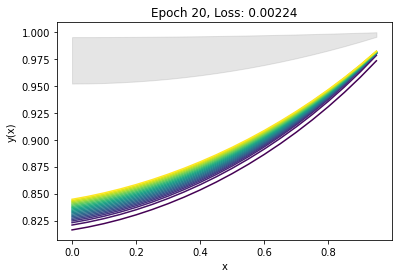

13:47:23.689 [INFO] W = [ 0.1766,  0.1302,  0.1157,  0.0687,  0.2374,  0.0879,  0.2018,  0.1510,  0.1353,  0.0847,  0.2685,  0.1043,  0.0396,  0.0051,  0.2029,  0.1755,  0.1634,  0.1360,  0.2448,  0.0648,  0.0000,  0.0068,  0.1562,  0.1056,  0.1241,  0.0737,  0.1892,  0.1373,  0.1502,  0.0614,  0.1563,  0.1279,  0.1084,  0.0812,  0.2034,  0.1216,  0.1438,  0.0594,  0.1848,  0.1561,  0.1119,  0.0835,  0.2571,  0.0954,  0.0910,  0.0188, -0.0271]
13:47:23.694 [INFO] Pruning weights...
13:47:23.700 [INFO] Shed 0.06866598129272461 weight
13:47:23.831 [INFO] Constructed symbolic model
13:47:23.867 [INFO] Integrated
13:47:24.178 [INFO] Added boundary condition
13:47:24.598 [INFO] Lambdified
13:47:24.598 [INFO] Constructed JAXified model


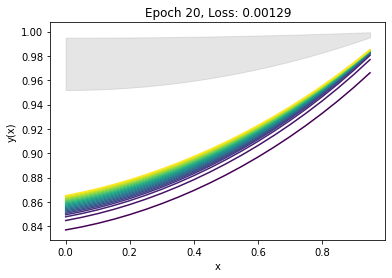

13:47:28.178 [INFO] W = [ 0.1769,  0.1302,  0.1156,  0.2379,  0.0865,  0.2053,  0.1532,  0.1367,  0.0849,  0.2740,  0.1036,  0.0352,  0.0017,  0.2044,  0.1812,  0.1665,  0.1433,  0.2447,  0.0543,  0.0001,  0.0022,  0.1569,  0.1050,  0.1245,  0.0729,  0.1902,  0.1380,  0.1509,  0.0606,  0.1549,  0.1307,  0.1064,  0.0833,  0.2028,  0.1201,  0.1425,  0.0614,  0.1845,  0.1599,  0.1107,  0.0865,  0.2575,  0.0927,  0.0885,  0.0201, -0.0230]
13:47:28.182 [INFO] Pruning weights...
13:47:28.189 [INFO] Shed 0.0865188017487526 weight
13:47:28.329 [INFO] Constructed symbolic model
13:47:28.362 [INFO] Integrated
13:47:28.563 [INFO] Added boundary condition
13:47:28.888 [INFO] Lambdified
13:47:28.889 [INFO] Constructed JAXified model


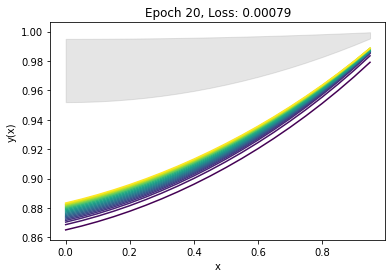

13:47:32.118 [INFO] W = [ 0.1768,  0.1303,  0.1159,  0.2375,  0.2074,  0.1545,  0.1374,  0.0848,  0.2775,  0.1030,  0.0321,  0.0000,  0.2056,  0.1850,  0.1677,  0.1471,  0.2459,  0.0463, -0.0000,  0.0001,  0.1572,  0.1046,  0.1249,  0.0725,  0.1904,  0.1383,  0.1513,  0.0602,  0.1538,  0.1323,  0.1056,  0.0851,  0.2013,  0.1189,  0.1413,  0.0632,  0.1840,  0.1621,  0.1098,  0.0882,  0.2577,  0.0908,  0.0868,  0.0207, -0.0204]
13:47:32.122 [INFO] Pruning weights...
13:47:32.129 [INFO] Shed 0.11591586470603943 weight
13:47:32.257 [INFO] Constructed symbolic model
13:47:32.286 [INFO] Integrated
13:47:32.463 [INFO] Added boundary condition
13:47:32.731 [INFO] Lambdified
13:47:32.732 [INFO] Constructed JAXified model


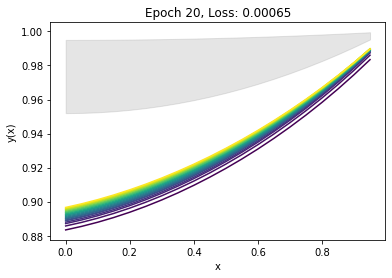

13:47:35.828 [INFO] W = [ 0.1769,  0.1306,  0.2369,  0.2088,  0.1552,  0.1377,  0.0844,  0.2800,  0.1021,  0.0292,  0.0001,  0.2065,  0.1879,  0.1684,  0.1497,  0.2471,  0.0381,  0.0001,  0.0001,  0.1575,  0.1041,  0.1253,  0.0722,  0.1905,  0.1385,  0.1515,  0.0598,  0.1531,  0.1334,  0.1051,  0.0865,  0.2003,  0.1177,  0.1406,  0.0644,  0.1840,  0.1639,  0.1088,  0.0891,  0.2585,  0.0892,  0.0857,  0.0206, -0.0185]
13:47:35.832 [INFO] Pruning weights...
13:47:35.837 [INFO] Shed 0.13061392307281494 weight
13:47:35.922 [INFO] Constructed symbolic model
13:47:35.952 [INFO] Integrated
13:47:36.750 [INFO] Added boundary condition
13:47:36.275 [INFO] Lambdified
13:47:36.275 [INFO] Constructed JAXified model


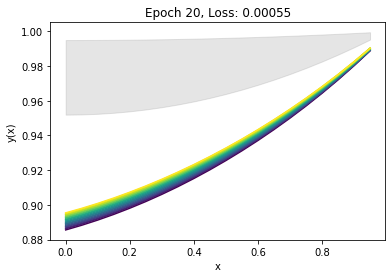

13:47:39.970 [INFO] W = [ 0.1771,  0.2363,  0.2100,  0.1558,  0.1379,  0.0839,  0.2822,  0.1014,  0.0267,  0.0002,  0.2076,  0.1904,  0.1683,  0.1511,  0.2493,  0.0312,  0.0001,  0.0001,  0.1577,  0.1037,  0.1258,  0.0720,  0.1905,  0.1386,  0.1517,  0.0596,  0.1525,  0.1343,  0.1049,  0.0877,  0.1995,  0.1167,  0.1400,  0.0654,  0.1840,  0.1654,  0.1082,  0.0899,  0.2592,  0.0880,  0.0848,  0.0206, -0.0170]
13:47:39.101 [INFO] Pruning weights...
13:47:39.107 [INFO] Shed 0.177076056599617 weight
13:47:39.193 [INFO] Constructed symbolic model
13:47:39.222 [INFO] Integrated
13:47:39.297 [INFO] Added boundary condition
13:47:39.470 [INFO] Lambdified
13:47:39.470 [INFO] Constructed JAXified model


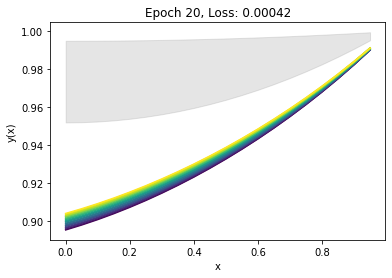

13:47:42.375 [INFO] W = [ 0.2357,  0.2109,  0.1562,  0.1380,  0.0836,  0.2840,  0.1008,  0.0247,  0.0001,  0.2085,  0.1926,  0.1680,  0.1520,  0.2514,  0.0256,  0.0001,  0.0001,  0.1579,  0.1034,  0.1261,  0.0719,  0.1904,  0.1386,  0.1519,  0.0595,  0.1520,  0.1351,  0.1047,  0.0888,  0.1987,  0.1159,  0.1394,  0.0663,  0.1840,  0.1666,  0.1076,  0.0906,  0.2597,  0.0870,  0.0841,  0.0206, -0.0158]
13:47:42.380 [INFO] Pruning weights...
13:47:42.389 [INFO] Shed 0.00013595080235973 weight
13:47:42.467 [INFO] Constructed symbolic model
13:47:42.496 [INFO] Integrated
13:47:42.606 [INFO] Added boundary condition
13:47:42.801 [INFO] Lambdified
13:47:42.801 [INFO] Constructed JAXified model


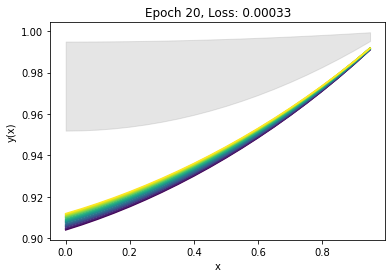

13:47:45.608 [INFO] W = [ 0.2353,  0.2115,  0.1564,  0.1378,  0.0830,  0.2853,  0.1001,  0.0228,  0.2093,  0.1945,  0.1676,  0.1527,  0.2535,  0.0208,  0.0000,  0.0000,  0.1580,  0.1032,  0.1264,  0.0719,  0.1904,  0.1387,  0.1520,  0.0594,  0.1516,  0.1358,  0.1045,  0.0898,  0.1980,  0.1151,  0.1389,  0.0671,  0.1838,  0.1676,  0.1071,  0.0912,  0.2599,  0.0862,  0.0835,  0.0208, -0.0147]
13:47:45.612 [INFO] Pruning weights...
13:47:45.617 [INFO] Shed 0.02283899486064911 weight
13:47:45.697 [INFO] Constructed symbolic model
13:47:45.735 [INFO] Integrated
13:47:45.853 [INFO] Added boundary condition
13:47:46.420 [INFO] Lambdified
13:47:46.430 [INFO] Constructed JAXified model


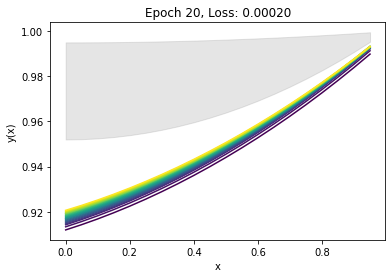

13:47:48.880 [INFO] W = [ 0.2350,  0.2116,  0.1565,  0.1376,  0.0828,  0.2857,  0.0997,  0.2099,  0.1961,  0.1669,  0.1531,  0.2552,  0.0176,  0.0000,  0.0001,  0.1580,  0.1032,  0.1265,  0.0719,  0.1903,  0.1386,  0.1520,  0.0594,  0.1512,  0.1364,  0.1044,  0.0907,  0.1973,  0.1145,  0.1385,  0.0679,  0.1835,  0.1683,  0.1070,  0.0921,  0.2594,  0.0858,  0.0830,  0.0216, -0.0136]
13:47:48.884 [INFO] Pruning weights...
13:47:48.889 [INFO] Shed 0.08280446380376816 weight
13:47:48.961 [INFO] Constructed symbolic model
13:47:49.100 [INFO] Integrated
13:47:49.101 [INFO] Added boundary condition
13:47:49.280 [INFO] Lambdified
13:47:49.280 [INFO] Constructed JAXified model


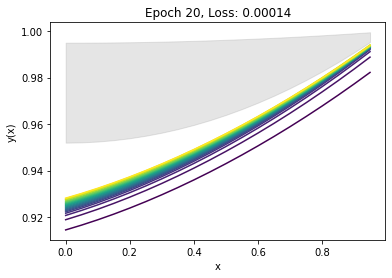

13:47:51.880 [INFO] W = [ 0.2348,  0.2116,  0.1566,  0.1376,  0.2857,  0.0996,  0.2097,  0.1977,  0.1664,  0.1543,  0.2555,  0.0157,  0.0001,  0.0000,  0.1580,  0.1032,  0.1265,  0.0720,  0.1903,  0.1386,  0.1520,  0.0595,  0.1505,  0.1375,  0.1038,  0.0918,  0.1965,  0.1137,  0.1378,  0.0691,  0.1827,  0.1692,  0.1067,  0.0936,  0.2580,  0.0852,  0.0823,  0.0232, -0.0119]
13:47:51.883 [INFO] Pruning weights...
13:47:51.888 [INFO] Shed 0.09956046938896179 weight
13:47:51.955 [INFO] Constructed symbolic model
13:47:51.985 [INFO] Integrated
13:47:52.900 [INFO] Added boundary condition
13:47:52.253 [INFO] Lambdified
13:47:52.254 [INFO] Constructed JAXified model


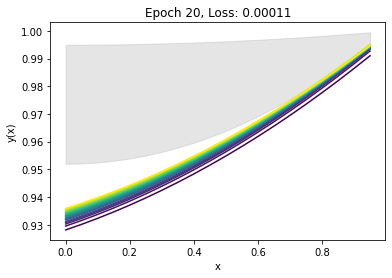

13:47:54.990 [INFO] W = [ 0.2348,  0.2116,  0.1566,  0.1375,  0.2857,  0.2099,  0.1988,  0.1656,  0.1544,  0.2566,  0.0141,  0.0001,  0.0001,  0.1579,  0.1033,  0.1265,  0.0720,  0.1903,  0.1386,  0.1519,  0.0595,  0.1501,  0.1380,  0.1036,  0.0926,  0.1959,  0.1132,  0.1374,  0.0698,  0.1822,  0.1696,  0.1067,  0.0945,  0.2570,  0.0848,  0.0818,  0.0242, -0.0109]
13:47:54.994 [INFO] Pruning weights...
13:47:54.1000 [INFO] Shed 0.13754111528396606 weight
13:47:55.640 [INFO] Constructed symbolic model
13:47:55.970 [INFO] Integrated
13:47:55.191 [INFO] Added boundary condition
13:47:55.361 [INFO] Lambdified
13:47:55.362 [INFO] Constructed JAXified model


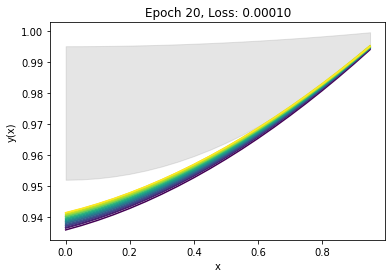

13:47:57.990 [INFO] W = [ 0.2346,  0.2116,  0.1567,  0.2856,  0.2102,  0.1997,  0.1652,  0.1547,  0.2577,  0.0114,  0.0002,  0.0001,  0.1579,  0.1033,  0.1264,  0.0720,  0.1903,  0.1386,  0.1519,  0.0595,  0.1498,  0.1383,  0.1036,  0.0931,  0.1954,  0.1128,  0.1371,  0.0702,  0.1818,  0.1699,  0.1068,  0.0952,  0.2562,  0.0845,  0.0814,  0.0249, -0.0103]
13:47:57.994 [INFO] Pruning weights...
13:47:57.999 [INFO] Shed 0.1567164659500122 weight
13:47:58.620 [INFO] Constructed symbolic model
13:47:58.104 [INFO] Integrated
13:47:58.190 [INFO] Added boundary condition
13:47:58.351 [INFO] Lambdified
13:47:58.351 [INFO] Constructed JAXified model


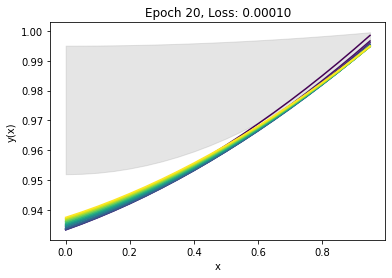

13:48:00.996 [INFO] W = [ 0.2345,  0.2116,  0.2855,  0.2109,  0.2006,  0.1642,  0.1539,  0.2599,  0.0095,  0.0000,  0.0001,  0.1579,  0.1034,  0.1264,  0.0721,  0.1903,  0.1386,  0.1519,  0.0596,  0.1497,  0.1384,  0.1038,  0.0936,  0.1949,  0.1125,  0.1369,  0.0706,  0.1816,  0.1699,  0.1071,  0.0957,  0.2554,  0.0843,  0.0812,  0.0255, -0.0101]
13:48:00.999 [INFO] Pruning weights...
13:48:01.400 [INFO] Shed 0.21159356832504272 weight
13:48:01.600 [INFO] Constructed symbolic model
13:48:01.103 [INFO] Integrated
13:48:01.167 [INFO] Added boundary condition
13:48:01.315 [INFO] Lambdified
13:48:01.316 [INFO] Constructed JAXified model


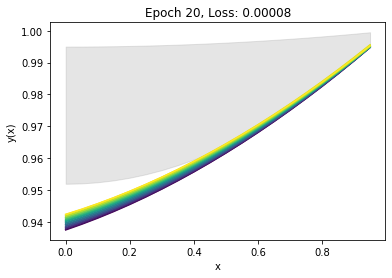

13:48:04.740 [INFO] W = [ 0.2344,  0.2854,  0.2112,  0.2015,  0.1635,  0.1537,  0.2614,  0.0080,  0.0002,  0.0001,  0.1579,  0.1034,  0.1263,  0.0721,  0.1903,  0.1385,  0.1519,  0.0596,  0.1494,  0.1387,  0.1038,  0.0942,  0.1944,  0.1121,  0.1367,  0.0712,  0.1812,  0.1701,  0.1072,  0.0964,  0.2547,  0.0840,  0.0808,  0.0262, -0.0095]
13:48:04.770 [INFO] Pruning weights...
13:48:04.820 [INFO] Shed 8.830525621306151e-05 weight
13:48:04.148 [INFO] Constructed symbolic model
13:48:04.180 [INFO] Integrated
13:48:04.283 [INFO] Added boundary condition
13:48:04.445 [INFO] Lambdified
13:48:04.446 [INFO] Constructed JAXified model


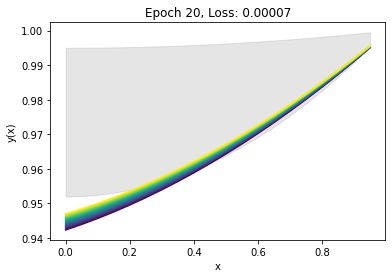

13:48:07.118 [INFO] W = [ 0.2344,  0.2853,  0.2113,  0.2022,  0.1627,  0.1536,  0.2624,  0.0066,  0.0001,  0.1578,  0.1035,  0.1263,  0.0721,  0.1903,  0.1385,  0.1519,  0.0597,  0.1492,  0.1391,  0.1037,  0.0947,  0.1939,  0.1118,  0.1364,  0.0717,  0.1809,  0.1704,  0.1072,  0.0971,  0.2540,  0.0837,  0.0805,  0.0268, -0.0089]
13:48:07.121 [INFO] Pruning weights...
13:48:07.128 [INFO] Shed 0.0001080544971046038 weight
13:48:07.205 [INFO] Constructed symbolic model
13:48:07.244 [INFO] Integrated
13:48:07.330 [INFO] Added boundary condition
13:48:07.488 [INFO] Lambdified
13:48:07.489 [INFO] Constructed JAXified model


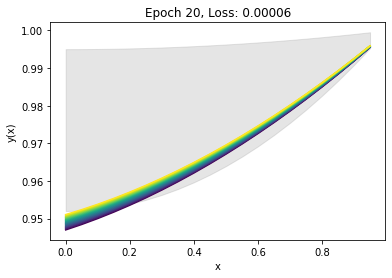

13:48:09.957 [INFO] W = [ 0.2343,  0.2853,  0.2115,  0.2029,  0.1620,  0.1534,  0.2634,  0.0054,  0.1578,  0.1035,  0.1262,  0.0722,  0.1903,  0.1385,  0.1518,  0.0597,  0.1489,  0.1394,  0.1037,  0.0952,  0.1935,  0.1115,  0.1361,  0.0721,  0.1806,  0.1706,  0.1073,  0.0977,  0.2533,  0.0834,  0.0802,  0.0274, -0.0084]
13:48:09.961 [INFO] Pruning weights...
13:48:09.965 [INFO] Shed 0.00539532583206892 weight
13:48:10.180 [INFO] Constructed symbolic model
13:48:10.500 [INFO] Integrated
13:48:10.128 [INFO] Added boundary condition
13:48:10.272 [INFO] Lambdified
13:48:10.273 [INFO] Constructed JAXified model


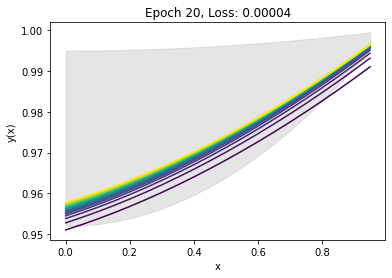

13:48:12.695 [INFO] W = [ 0.2344,  0.2853,  0.2112,  0.2036,  0.1614,  0.1538,  0.2634,  0.1578,  0.1035,  0.1262,  0.0722,  0.1903,  0.1385,  0.1518,  0.0597,  0.1486,  0.1400,  0.1034,  0.0958,  0.1931,  0.1111,  0.1358,  0.0728,  0.1802,  0.1711,  0.1072,  0.0985,  0.2525,  0.0831,  0.0798,  0.0283, -0.0074]
13:48:12.698 [INFO] Pruning weights...
13:48:12.704 [INFO] Shed 0.15376846492290497 weight
13:48:12.783 [INFO] Constructed symbolic model
13:48:12.822 [INFO] Integrated
13:48:12.897 [INFO] Added boundary condition
13:48:13.450 [INFO] Lambdified
13:48:13.460 [INFO] Constructed JAXified model


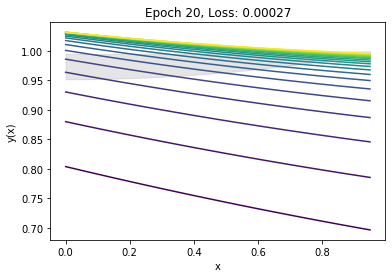

13:48:15.528 [INFO] W = [ 0.2331,  0.2850,  0.2031,  0.2371,  0.1988,  0.2098,  0.1579,  0.1033,  0.1263,  0.0719,  0.1905,  0.1386,  0.1520,  0.0594,  0.1360,  0.1690,  0.0802,  0.1143,  0.1912,  0.1008,  0.1234,  0.0922,  0.1664,  0.1990,  0.0899,  0.1228,  0.2423,  0.0688,  0.0660,  0.0523,  0.0341]
13:48:15.532 [INFO] Pruning weights...
13:48:15.537 [INFO] Shed 0.19881616532802582 weight
13:48:15.587 [INFO] Constructed symbolic model
13:48:15.623 [INFO] Integrated
13:48:15.694 [INFO] Added boundary condition
13:48:15.835 [INFO] Lambdified
13:48:15.835 [INFO] Constructed JAXified model


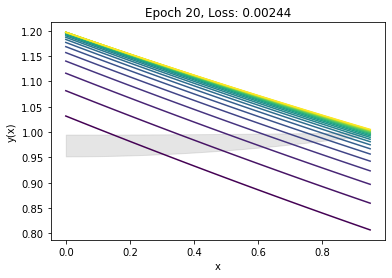

13:48:18.128 [INFO] W = [ 0.2308,  0.2829,  0.2051,  0.2704,  0.1686,  0.1580,  0.1034,  0.1258,  0.0715,  0.1910,  0.1387,  0.1520,  0.0591,  0.1262,  0.1905,  0.0604,  0.1257,  0.1914,  0.0926,  0.1136,  0.1044,  0.1560,  0.2198,  0.0741,  0.1383,  0.2372,  0.0567,  0.0553,  0.0670,  0.0655]
13:48:18.132 [INFO] Pruning weights...
13:48:18.137 [INFO] Shed 0.16859522461891174 weight
13:48:18.183 [INFO] Constructed symbolic model
13:48:18.233 [INFO] Integrated
13:48:18.307 [INFO] Added boundary condition
13:48:18.459 [INFO] Lambdified
13:48:18.459 [INFO] Constructed JAXified model


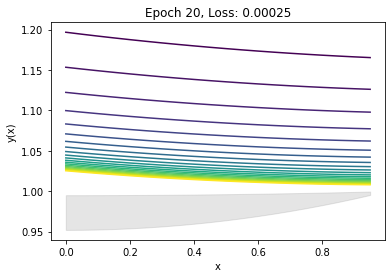

13:48:20.961 [INFO] W = [ 0.2311,  0.2831,  0.2127,  0.2483,  0.1582,  0.1032,  0.1261,  0.0713,  0.1912,  0.1389,  0.1522,  0.0589,  0.1345,  0.1691,  0.0751,  0.1107,  0.1932,  0.0993,  0.1218,  0.0887,  0.1653,  0.1995,  0.0845,  0.1191,  0.2454,  0.0657,  0.0646,  0.0475,  0.0358]
13:48:20.965 [INFO] Pruning weights...
13:48:20.970 [INFO] Shed 0.2127002626657486 weight
13:48:21.280 [INFO] Constructed symbolic model
13:48:21.640 [INFO] Integrated
13:48:21.127 [INFO] Added boundary condition
13:48:21.245 [INFO] Lambdified
13:48:21.245 [INFO] Constructed JAXified model


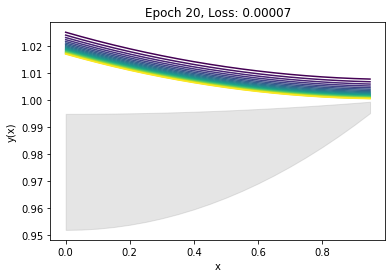

13:48:23.545 [INFO] W = [ 0.2310,  0.2830,  0.2462,  0.1582,  0.1031,  0.1261,  0.0712,  0.1912,  0.1390,  0.1523,  0.0588,  0.1361,  0.1686,  0.0768,  0.1103,  0.1948,  0.1008,  0.1234,  0.0882,  0.1672,  0.1992,  0.0860,  0.1184,  0.2477,  0.0673,  0.0664,  0.0466,  0.0336]
13:48:23.548 [INFO] Pruning weights...
13:48:23.554 [INFO] Shed 0.05876157805323601 weight
13:48:23.603 [INFO] Constructed symbolic model
13:48:23.637 [INFO] Integrated
13:48:23.730 [INFO] Added boundary condition
13:48:23.861 [INFO] Lambdified
13:48:23.862 [INFO] Constructed JAXified model


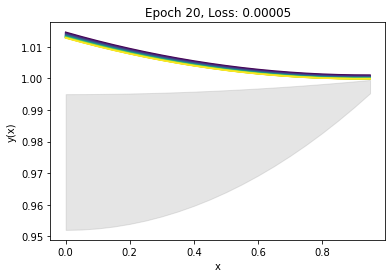

13:48:26.259 [INFO] W = [ 0.2308,  0.2829,  0.2459,  0.1583,  0.1030,  0.1261,  0.0711,  0.1913,  0.1390,  0.1523,  0.1364,  0.1686,  0.0767,  0.1101,  0.1953,  0.1010,  0.1237,  0.0880,  0.1675,  0.1993,  0.0859,  0.1181,  0.2484,  0.0674,  0.0668,  0.0462,  0.0334]
13:48:26.263 [INFO] Pruning weights...
13:48:26.268 [INFO] Shed 0.07112571597099304 weight
13:48:26.326 [INFO] Constructed symbolic model
13:48:26.366 [INFO] Integrated
13:48:26.435 [INFO] Added boundary condition
13:48:26.566 [INFO] Lambdified
13:48:26.566 [INFO] Constructed JAXified model


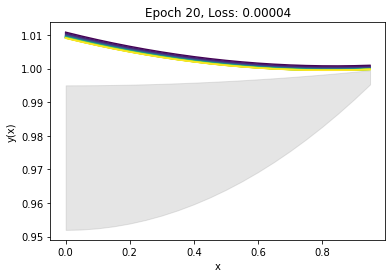

13:48:28.727 [INFO] W = [ 0.2307,  0.2829,  0.2458,  0.1583,  0.1030,  0.1261,  0.1913,  0.1390,  0.1523,  0.1365,  0.1686,  0.0766,  0.1098,  0.1957,  0.1012,  0.1238,  0.0877,  0.1677,  0.1993,  0.0858,  0.1178,  0.2489,  0.0675,  0.0669,  0.0459,  0.0332]
13:48:28.730 [INFO] Pruning weights...
13:48:28.736 [INFO] Shed 0.10296336561441422 weight
13:48:28.783 [INFO] Constructed symbolic model
13:48:28.834 [INFO] Integrated
13:48:28.905 [INFO] Added boundary condition
13:48:29.280 [INFO] Lambdified
13:48:29.280 [INFO] Constructed JAXified model


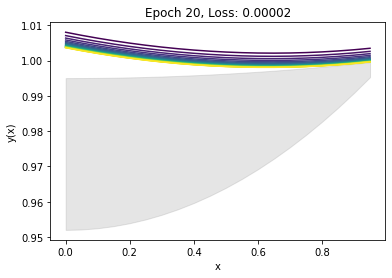

13:48:31.244 [INFO] W = [ 0.2307,  0.2829,  0.2450,  0.1583,  0.1261,  0.1913,  0.1390,  0.1523,  0.1368,  0.1681,  0.0769,  0.1093,  0.1960,  0.1014,  0.1241,  0.0872,  0.1679,  0.1989,  0.0860,  0.1173,  0.2493,  0.0677,  0.0672,  0.0454,  0.0325]
13:48:31.247 [INFO] Pruning weights...
13:48:31.254 [INFO] Shed 0.1261153519153595 weight
13:48:31.289 [INFO] Constructed symbolic model
13:48:31.320 [INFO] Integrated
13:48:31.388 [INFO] Added boundary condition
13:48:31.492 [INFO] Lambdified
13:48:31.493 [INFO] Constructed JAXified model


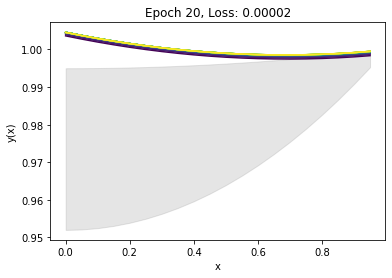

13:48:33.545 [INFO] W = [ 0.2306,  0.2829,  0.2453,  0.1583,  0.1913,  0.1390,  0.1523,  0.1368,  0.1684,  0.0766,  0.1093,  0.1963,  0.1014,  0.1241,  0.0872,  0.1680,  0.1991,  0.0858,  0.1173,  0.2495,  0.0678,  0.0672,  0.0454,  0.0327]
13:48:33.548 [INFO] Pruning weights...
13:48:33.553 [INFO] Shed 0.13899093866348267 weight
13:48:33.593 [INFO] Constructed symbolic model
13:48:33.651 [INFO] Integrated
13:48:33.697 [INFO] Added boundary condition
13:48:33.799 [INFO] Lambdified
13:48:33.799 [INFO] Constructed JAXified model


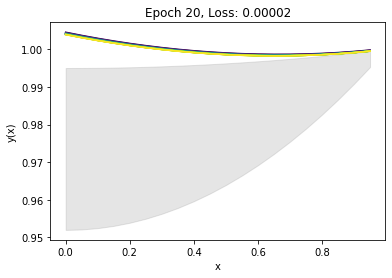

13:48:35.947 [INFO] W = [ 0.2305,  0.2829,  0.2453,  0.1583,  0.1913,  0.1523,  0.1368,  0.1684,  0.0765,  0.1091,  0.1965,  0.1015,  0.1241,  0.0870,  0.1680,  0.1991,  0.0856,  0.1171,  0.2498,  0.0678,  0.0673,  0.0452,  0.0327]
13:48:35.950 [INFO] Pruning weights...
13:48:35.956 [INFO] Shed 0.15230296552181244 weight
13:48:35.983 [INFO] Constructed symbolic model
13:48:36.190 [INFO] Integrated
13:48:36.480 [INFO] Added boundary condition
13:48:36.128 [INFO] Lambdified
13:48:36.128 [INFO] Constructed JAXified model


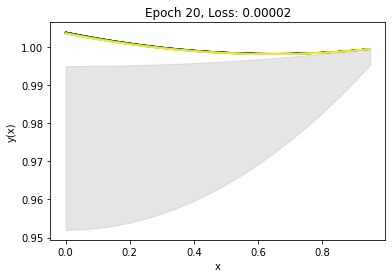

13:48:37.986 [INFO] W = [ 0.2305,  0.2829,  0.2453,  0.1583,  0.1913,  0.1369,  0.1685,  0.0763,  0.1090,  0.1968,  0.1015,  0.1242,  0.0869,  0.1680,  0.1992,  0.0854,  0.1170,  0.2500,  0.0679,  0.0673,  0.0451,  0.0328]
13:48:37.989 [INFO] Pruning weights...
13:48:37.994 [INFO] Shed 0.15826301276683807 weight
13:48:38.200 [INFO] Constructed symbolic model
13:48:38.590 [INFO] Integrated
13:48:38.720 [INFO] Added boundary condition
13:48:38.139 [INFO] Lambdified
13:48:38.140 [INFO] Constructed JAXified model


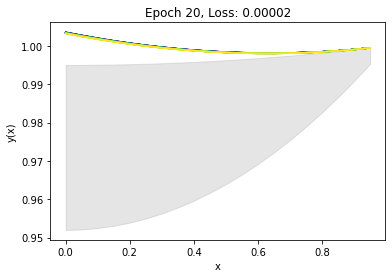

13:48:39.912 [INFO] W = [ 0.2304,  0.2829,  0.2453,  0.1913,  0.1369,  0.1685,  0.0761,  0.1088,  0.1970,  0.1015,  0.1242,  0.0867,  0.1681,  0.1993,  0.0853,  0.1168,  0.2503,  0.0679,  0.0674,  0.0449,  0.0328]
13:48:39.916 [INFO] Pruning weights...
13:48:39.921 [INFO] Shed 0.07614711672067642 weight
13:48:39.953 [INFO] Constructed symbolic model
13:48:40.115 [INFO] Integrated
13:48:40.131 [INFO] Added boundary condition
13:48:40.204 [INFO] Lambdified
13:48:40.205 [INFO] Constructed JAXified model


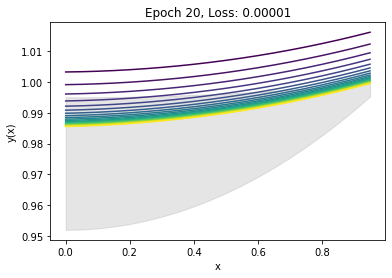

13:48:42.400 [INFO] W = [ 0.2302,  0.2827,  0.2419,  0.1913,  0.1381,  0.1663,  0.1074,  0.1974,  0.1026,  0.1254,  0.0852,  0.1691,  0.1969,  0.0871,  0.1152,  0.2504,  0.0687,  0.0684,  0.0432,  0.0293]
13:48:42.800 [INFO] Pruning weights...
13:48:42.140 [INFO] Shed 0.08523844182491302 weight
13:48:42.370 [INFO] Constructed symbolic model
13:48:42.880 [INFO] Integrated
13:48:42.115 [INFO] Added boundary condition
13:48:42.191 [INFO] Lambdified
13:48:42.191 [INFO] Constructed JAXified model


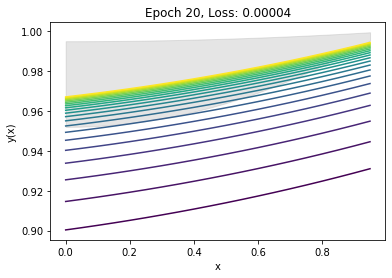

13:48:43.911 [INFO] W = [ 0.2319,  0.2833,  0.2555,  0.1912,  0.1342,  0.1759,  0.1141,  0.1964,  0.0994,  0.1215,  0.1652,  0.2065,  0.0802,  0.1219,  0.2495,  0.0656,  0.0645,  0.0502,  0.0429]
13:48:43.914 [INFO] Pruning weights...
13:48:43.919 [INFO] Shed 0.09939532727003098 weight
13:48:43.942 [INFO] Constructed symbolic model
13:48:44.200 [INFO] Integrated
13:48:44.330 [INFO] Added boundary condition
13:48:44.110 [INFO] Lambdified
13:48:44.111 [INFO] Constructed JAXified model


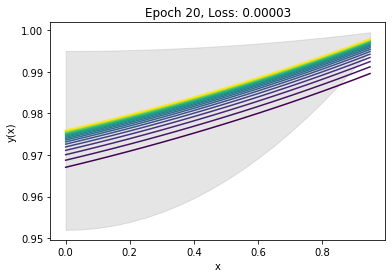

13:48:45.793 [INFO] W = [ 0.2320,  0.2835,  0.2575,  0.1912,  0.1336,  0.1773,  0.1153,  0.1960,  0.1209,  0.1641,  0.2074,  0.0789,  0.1225,  0.2487,  0.0647,  0.0634,  0.0510,  0.0449]
13:48:45.796 [INFO] Pruning weights...
13:48:45.801 [INFO] Shed 0.1152527928352356 weight
13:48:45.821 [INFO] Constructed symbolic model
13:48:45.966 [INFO] Integrated
13:48:45.979 [INFO] Added boundary condition
13:48:46.400 [INFO] Lambdified
13:48:46.410 [INFO] Constructed JAXified model


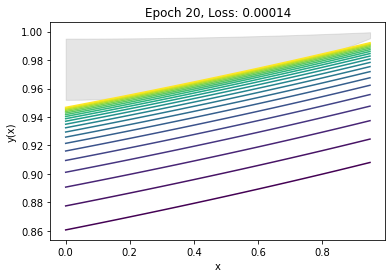

13:48:47.605 [INFO] W = [ 0.2353,  0.2843,  0.2768,  0.1910,  0.1293,  0.1923,  0.1957,  0.1167,  0.1582,  0.2208,  0.0689,  0.1319,  0.2469,  0.0600,  0.0576,  0.0609,  0.0642]
13:48:47.608 [INFO] Pruning weights...
13:48:47.613 [INFO] Shed 0.11668351292610168 weight
13:48:47.636 [INFO] Constructed symbolic model
13:48:47.690 [INFO] Integrated
13:48:47.724 [INFO] Added boundary condition
13:48:47.781 [INFO] Lambdified
13:48:47.782 [INFO] Constructed JAXified model


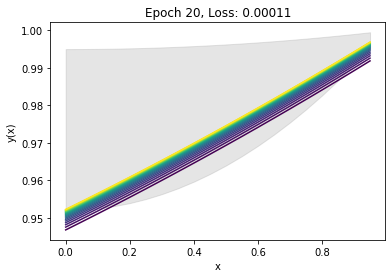

13:48:49.376 [INFO] W = [ 0.2352,  0.2844,  0.2783,  0.1910,  0.1290,  0.1935,  0.1952,  0.1570,  0.2211,  0.0679,  0.1323,  0.2456,  0.0590,  0.0565,  0.0614,  0.0657]
13:48:49.380 [INFO] Pruning weights...
13:48:49.385 [INFO] Shed 0.1289728283882141 weight
13:48:49.406 [INFO] Constructed symbolic model
13:48:49.450 [INFO] Integrated
13:48:49.461 [INFO] Added boundary condition
13:48:49.506 [INFO] Lambdified
13:48:49.506 [INFO] Constructed JAXified model


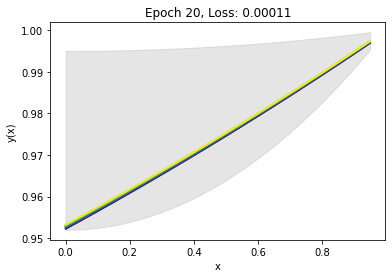

13:48:51.460 [INFO] W = [ 0.2348,  0.2845,  0.2784,  0.1909,  0.1936,  0.1948,  0.1568,  0.2210,  0.0681,  0.1327,  0.2448,  0.0589,  0.0562,  0.0618,  0.0658]
13:48:51.490 [INFO] Pruning weights...
13:48:51.540 [INFO] Shed 0.1936432123184204 weight
13:48:51.710 [INFO] Constructed symbolic model
13:48:51.122 [INFO] Integrated
13:48:51.150 [INFO] Added boundary condition
13:48:51.218 [INFO] Lambdified
13:48:51.219 [INFO] Constructed JAXified model


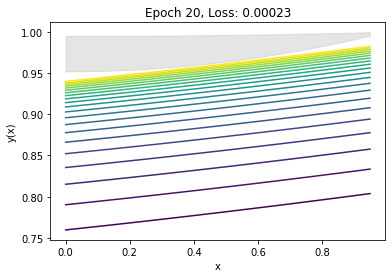

13:48:52.809 [INFO] W = [ 0.2440,  0.2852,  0.3273,  0.1908,  0.2060,  0.1425,  0.2555,  0.0426,  0.1560,  0.2417,  0.0474,  0.0421,  0.0865,  0.1146]
13:48:52.812 [INFO] Pruning weights...
13:48:52.817 [INFO] Shed 0.04209185391664505 weight
13:48:52.830 [INFO] Constructed symbolic model
13:48:52.864 [INFO] Integrated
13:48:52.883 [INFO] Added boundary condition
13:48:52.936 [INFO] Lambdified
13:48:52.937 [INFO] Constructed JAXified model


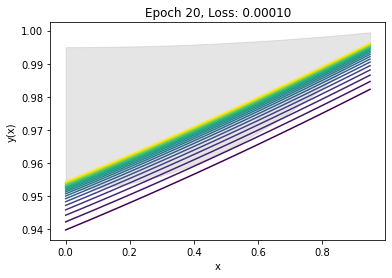

13:48:54.377 [INFO] W = [ 0.2444,  0.2853,  0.3311,  0.1907,  0.2065,  0.1411,  0.2581,  0.0408,  0.1581,  0.2408,  0.0464,  0.0887,  0.1185]
13:48:54.380 [INFO] Pruning weights...
13:48:54.385 [INFO] Shed 0.0408141054213047 weight
13:48:54.463 [INFO] Constructed symbolic model
13:48:54.511 [INFO] Integrated
13:48:54.523 [INFO] Added boundary condition
13:48:54.569 [INFO] Lambdified
13:48:54.570 [INFO] Constructed JAXified model


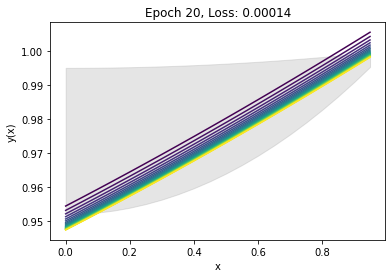

13:48:56.680 [INFO] W = [ 0.2434,  0.2853,  0.3288,  0.1907,  0.2053,  0.1420,  0.2565,  0.1577,  0.2405,  0.0472,  0.0883,  0.1161]
13:48:56.710 [INFO] Pruning weights...
13:48:56.760 [INFO] Shed 0.047173768281936646 weight
13:48:56.840 [INFO] Constructed symbolic model
13:48:56.134 [INFO] Integrated
13:48:56.154 [INFO] Added boundary condition
13:48:56.203 [INFO] Lambdified
13:48:56.203 [INFO] Constructed JAXified model


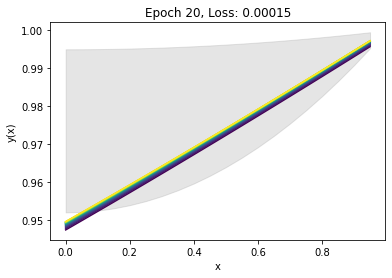

13:48:57.635 [INFO] W = [ 0.2429,  0.2854,  0.3292,  0.1907,  0.2048,  0.1417,  0.2566,  0.1583,  0.2397,  0.0890,  0.1165]
13:48:57.638 [INFO] Pruning weights...
13:48:57.643 [INFO] Shed 0.08895846456289291 weight
13:48:57.651 [INFO] Constructed symbolic model
13:48:57.716 [INFO] Integrated
13:48:57.735 [INFO] Added boundary condition
13:48:57.769 [INFO] Lambdified
13:48:57.770 [INFO] Constructed JAXified model


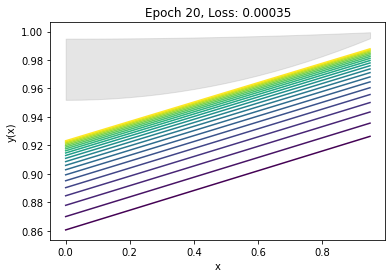

13:48:59.640 [INFO] W = [ 0.2461,  0.2866,  0.3494,  0.1904,  0.2089,  0.1347,  0.2698,  0.1674,  0.2367,  0.1367]
13:48:59.690 [INFO] Pruning weights...
13:48:59.740 [INFO] Shed 0.13465003669261932 weight
13:48:59.960 [INFO] Constructed symbolic model
13:48:59.149 [INFO] Integrated
13:48:59.150 [INFO] Added boundary condition
13:48:59.178 [INFO] Lambdified
13:48:59.179 [INFO] Constructed JAXified model


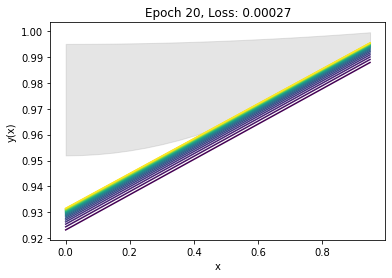

13:49:00.471 [INFO] W = [ 0.2460,  0.2866,  0.3519,  0.1904,  0.2086,  0.2713,  0.1692,  0.2354,  0.1392]
13:49:00.473 [INFO] Pruning weights...
13:49:00.480 [INFO] Shed 0.16918529570102692 weight
13:49:00.490 [INFO] Constructed symbolic model
13:49:00.679 [INFO] Integrated
13:49:00.686 [INFO] Added boundary condition
13:49:00.705 [INFO] Lambdified
13:49:00.705 [INFO] Constructed JAXified model


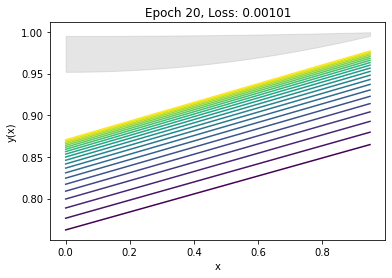

13:49:01.947 [INFO] W = [ 0.2517,  0.2947,  0.3917,  0.1884,  0.2171,  0.2997,  0.2323,  0.1791]
13:49:01.950 [INFO] Pruning weights...
13:49:01.954 [INFO] Shed 0.23230551183223724 weight
13:49:01.959 [INFO] Constructed symbolic model
13:49:02.200 [INFO] Integrated
13:49:02.320 [INFO] Added boundary condition
13:49:02.530 [INFO] Lambdified
13:49:02.540 [INFO] Constructed JAXified model


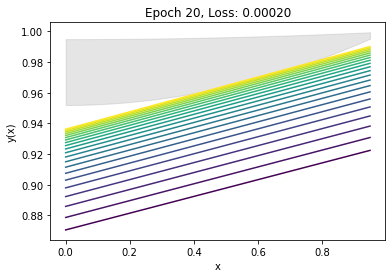

13:49:03.251 [INFO] W = [ 0.2559,  0.2947,  0.4136,  0.1884,  0.2220,  0.3216,  0.2010]
13:49:03.253 [INFO] Pruning weights...
13:49:03.260 [INFO] Constructed symbolic model
13:49:03.299 [INFO] Integrated
13:49:03.301 [INFO] Added boundary condition
13:49:03.316 [INFO] Lambdified
13:49:03.317 [INFO] Constructed JAXified model


Nothing more to prune!


In [37]:
plotting = Plotting(orig_func_klow, network, x_bounds, c1_bounds)

key = random.PRNGKey(7)

key, subkey = random.split(key)
W = random.uniform(subkey, shape=(len(network.alphas),), minval=0, maxval=0.001)

is_final = network.is_final

try: best
except: best = DotDict({"loss": np.inf})

if is_final:
    print('Network is final, no training')

while not is_final:
    plotting.funcs = []
    train_results = train(
        network,
        dataset = [(1, 1)],
        plotting = plotting,
        key = key,
        lr = 0.0002,
        lr_2 = 0.0003,
        epochs = 20,
        verbose = 0,
        batch_size = 16,
        W_init = W,
        best = best
    )

    W = train_results.W
    loss_history = train_results.loss_history

    info('Pruning weights...')
    network.assign_weights(W)
    W, model_y, loss_and_grad, is_final = network.prune_auto()

In [38]:
# for alpha in best.alphas:
#   d(alpha)

In [39]:
import re

for weight_sym, val in zip(best.alphas, best.W):
  weight = re.sub(r'a_o(\d)__0(\d)__0(\d)', r'\alpha_{o_\1}^{(\2, \3)}', weight_sym.name).replace('\x07', '\\a')
  print(f'${weight}$ & ', end='')
  val = round(float(val), 4)
  print(f'${val}$ \\\\')

$\alpha_{o_4}^{(0, 1)}$ & $0.2302$ \\
$\alpha_{o_4}^{(0, 2)}$ & $0.2827$ \\
$\alpha_{o_1}^{(0, 3)}$ & $0.2419$ \\
$\alpha_{o_4}^{(1, 2)}$ & $0.1913$ \\
$\alpha_{o_0}^{(1, 3)}$ & $0.1381$ \\
$\alpha_{o_1}^{(1, 3)}$ & $0.1663$ \\
$\alpha_{o_3}^{(1, 3)}$ & $0.1074$ \\
$\alpha_{o_4}^{(1, 3)}$ & $0.1974$ \\
$\alpha_{o_5}^{(1, 3)}$ & $0.1026$ \\
$\alpha_{o_6}^{(1, 3)}$ & $0.1254$ \\
$\alpha_{o_7}^{(1, 3)}$ & $0.0852$ \\
$\alpha_{o_0}^{(2, 3)}$ & $0.1691$ \\
$\alpha_{o_1}^{(2, 3)}$ & $0.1969$ \\
$\alpha_{o_2}^{(2, 3)}$ & $0.0871$ \\
$\alpha_{o_3}^{(2, 3)}$ & $0.1152$ \\
$\alpha_{o_4}^{(2, 3)}$ & $0.2504$ \\
$\alpha_{o_5}^{(2, 3)}$ & $0.0687$ \\
$\alpha_{o_6}^{(2, 3)}$ & $0.0684$ \\
$\alpha_{o_7}^{(2, 3)}$ & $0.0432$ \\
$b$ & $0.0293$ \\


In [40]:
float(best.loss)+1

1.0000180890838237

In [49]:
# y_prediction_last = model_y.subs(zip(network.alphas, W))
# y_prediction_last

In [42]:
y_prediction_best = best.model_y.subs(zip(best.alphas, best.W))
y_prediction_best

0.000573984299538078*x**4 + 0.00935040597191916*x**2 + 0.0321852873662438*x + 0.857084291055799 + 0.0432434156537056*exp(-0.238648342095613*x) + 0.0852382481098175*exp(-0.230192229151726*x)

In [43]:
# y_prediction_last_lambd = sp.lambdify([network.x], y_prediction_last, modules=network.lambdify_modules, cse=True)
y_prediction_best_lambd = sp.lambdify([network.x], y_prediction_best, modules=network.lambdify_modules, cse=True)

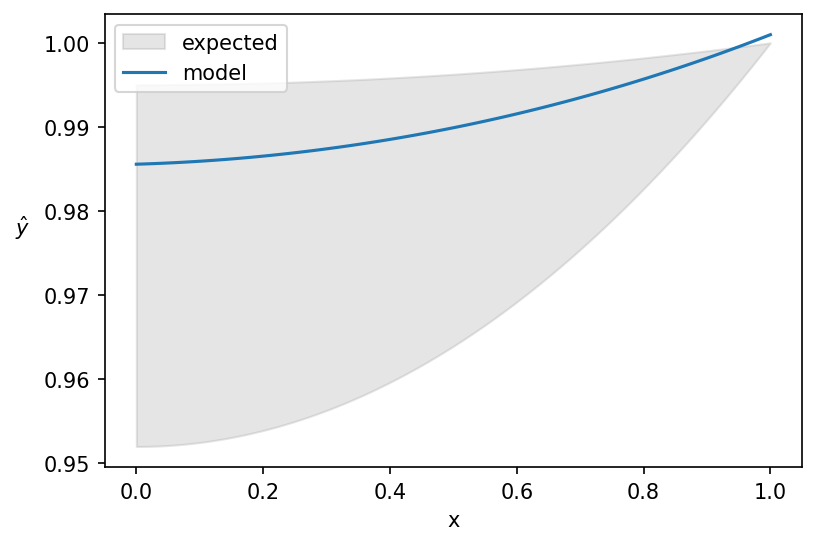

In [44]:
import matplotlib.pyplot as plt

xspace = np.linspace(*x_bounds, 100)

plotting.show_c2varied_plot(plotting.actual_func, xspace, plotting.c2_bounds)
# plt.plot(xspace, y_prediction_last_lambd(xspace), color='tab:orange', label='model last')
plt.plot(xspace, y_prediction_best_lambd(xspace), color='tab:blue', label='model')
plt.legend(loc=2)
plt.gcf().set_dpi(150)
plt.xlabel('x')
plt.ylabel('$\hat{y}$', rotation=0, labelpad=10)
plt.show()

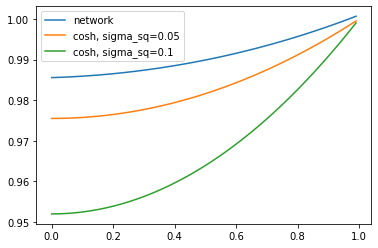

In [66]:
y_network_f = sp.lambdify(network.x, y_prediction_best)
x = np.arange(0, 1, 0.01)

y_network = y_network_f(x)
y_comp = orig_func_klow(x, 0.05)
y_comp2 = orig_func_klow(x, 0.1)

plt.plot(x, y_network, label='network')
plt.plot(x, y_comp, label='cosh, sigma_sq=0.05')
plt.plot(x, y_comp2, label='cosh, sigma_sq=0.1')
plt.legend()
plt.show()

In [69]:
def L2(y_pred, y_actual):
  return float(np.mean(np.square(np.array(y_pred) - np.array(y_actual))))

In [75]:
L2(y_network_f(x), orig_func_klow(x, 0.01))+1

1.0000417954361183

In [86]:
allsum = 0
for k in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]:
  val = L2(y_network_f(x), orig_func_klow(x, k))
  print(k, val+1, '- 1')
  allsum += val
allsum/10

0.01 1.0000417954361183 - 1
0.02 1.0000082023971117 - 1
0.03 1.0000008374630056 - 1
0.04 1.0000190778246179 - 1
0.05 1.0000623154992354 - 1
0.06 1.0001299592404393 - 1
0.07 1.0002214277046733 - 1
0.08 1.0003361538110767 - 1
0.09 1.0004735889087897 - 1
0.1 1.0006331952754408 - 1


0.0001926553560508637